In [1]:
%reload_ext autoreload

In [2]:
%autoreload 2

In [3]:
import re
import time

import pandas as pd
import numpy as np
import nltk
import warnings
import pickle
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split

In [4]:
from analyzer import data_cleaner
from analyzer.analyzer import TfidfDataTransformer

In [3]:
df_train = pd.read_csv('data/train.csv')
df_t = df_train.copy()

In [4]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
df_train['clean_tweet'] = np.vectorize(data_cleaner.clean_mentions)(df_train['tweet'])
df_train['clean_tweet'] = df_train['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))


df_train.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunctional and selfish drags hi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit can use cause they don...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model love take with all the time
4,5,0,factsguide: society now #motivation,factsguide society now #motivation


In [6]:


tr= TfidfDataTransformer()

df_train['clean_tweet'] = tr.stemming(df_train['clean_tweet'])
display(df_train.head())
#df_train['clean_tweet'].to_csv('models/model_data.csv', sep=',')
tr.vectorizer_fit(df_train['clean_tweet'])
df_tfidf = tr.transform(df_train['clean_tweet'])
pickle.dump(tr.vectorizer, open('models/vectorizer.sav', 'wb'))
x_train, x_valid, y_train, y_valid = train_test_split(df_tfidf, df_train['label'],test_size=0.3,random_state=42)

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunct and selfish drag hi kid i...
1,2,0,@user @user thanks for #lyft credit i can't us...,thank for #lyft credit can use caus they don o...
2,3,0,bihday your majesty,bihday your majesti
3,4,0,#model i love u take with u all the time in ...,#model love take with all the time
4,5,0,factsguide: society now #motivation,factsguid societi now #motiv


# Models and balancing

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score




model = LogisticRegression(random_state=0,solver='lbfgs')
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict_proba(x_valid)
predictions

In [ ]:
prediction_int = predictions[:,1]>=0.3
prediction_int = prediction_int.astype(np.int)
log_tfidf = f1_score(y_valid, prediction_int)

log_tfidf

In [ ]:
pickle.dump(model, open('../models/model.sav', 'wb'))
 

In [ ]:
test_data = tr.transform(['This thing is pretty shit', 'I like this pretty much, it is super', 'ugly bad ugly'])
model.predict_proba(test_data)


In [ ]:
from imblearn.under_sampling import TomekLinks,RandomUnderSampler, CondensedNearestNeighbour,EditedNearestNeighbours
#balancing

tl = RandomUnderSampler(sampling_strategy='not minority',random_state=1337) # default - will remove the sample from the majority class
#tl = TomekLinks(sampling_strategy='not minority',n_jobs = -1)
x_train_res, y_train_res = tl.fit_resample(x_train, y_train)
model2 = LogisticRegression(random_state=1337,solver='lbfgs')

model2.fit(x_train_res, y_train_res)


In [ ]:
pickle.dump(model, open('../models/model2.sav', 'wb'))

In [ ]:
predictions = model2.predict_proba(x_valid)
prediction_int = predictions[:,1]>=0.3
prediction_int = prediction_int.astype(np.int32)
log_tfidf = f1_score(y_valid, prediction_int)


In [ ]:
test_data = tr.transform(["it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia ", 'This thing is pretty shit', 'I like this pretty much, it is super', 'ugly bad ugly'])
model2.predict_proba(test_data)

In [ ]:
def analyze_data(model, data_path, data_transformer, data_balancer=None, save_model=True, save_vectorizer=True, verbose=True):
    data_name = data_path.split('/')[-1]
    name = f"{data_name}-{model.__repr__()}"
    if data_balancer is not None:
        name += '-balanced'
    if verbose:
        print(f'Analyzing {name}', end='')
    # Load data
    df_train = pd.read_csv(data_path)
    # Clean data
    df_train['clean_tweet'] = np.vectorize(data_cleaner.clean_mentions)(df_train['tweet'])
    df_train['clean_tweet'] = df_train['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
    df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    # Transform data
    df_train['clean_tweet'] = data_transformer.stemming(df_train['clean_tweet'])
    data_transformer.vectorizer_fit(df_train['clean_tweet'])
    df_tfidf = data_transformer.transform(df_train['clean_tweet'])
    if save_vectorizer:
        pickle.dump(data_transformer.vectorizer, open(f'../models/{data_name}-{data_transformer.vectorizer.__repr__()}.sav', 'wb'))
    x_train, x_valid, y_train, y_valid = train_test_split(df_tfidf, df_train['label'],test_size=0.3,random_state=1337)
    # Balance data
    if data_balancer is not None:
        x_train, y_train = data_balancer.fit_resample(x_train, y_train)
    # Fit model (HYPERPARAMS???)
    model.fit(x_train, y_train)
    if save_model:
        pickle.dump(model, open(f'../models/{name}.sav', 'wb'))
    # Predict
    if isinstance(model, (LogisticRegression, GaussianNB)):
        predictions = model.predict_proba(x_valid)
        prediction_int = predictions[:,1]>=0.3
        prediction_int = prediction_int.astype(np.int32)
    else:
        predictions = model.predict(x_valid)
        prediction_int = predictions[:]>=0.3
        prediction_int = prediction_int.astype(np.int32)
    # Evaluate
    metrics = {
        'f1_score': f1_score(y_valid, prediction_int)
    }
    #
    if verbose:
        print(f' ->> Done')
    return name, model, data_transformer ,predictions, metrics

In [ ]:
from sklearn.linear_model import LogisticRegression
from data_transformation import TfidfDataTransformer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks,RandomUnderSampler


name, model, tr, pred, metrics = analyze_data(model=LogisticRegression(random_state=0,solver='lbfgs'), data_path='data/train.csv', data_transformer=TfidfDataTransformer(), data_balancer=RandomUnderSampler(sampling_strategy='not minority',random_state=1337))




In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
test_data = tr.transform(["it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia ", 'This thing is pretty shit', 'life', 'ugly bad ugly'])

for m in [LogisticRegression(random_state=0,solver='lbfgs'), GaussianNB(), DecisionTreeRegressor()]:
    name, model, tr, pred, metrics = analyze_data(model=m, data_path='data/train.csv', data_transformer=TfidfDataTransformer(), data_balancer=RandomUnderSampler(sampling_strategy='not minority',random_state=1337))
    print(name)
    print(model.predict_proba(test_data))
    print(f'f1: {metrics["f1_score"]}')

In [ ]:
# Testing
name, model, tr, pred, metrics = analyze_data(model=DecisionTreeRegressor(), data_path='data/train.csv', data_transformer=TfidfDataTransformer(), data_balancer=RandomUnderSampler(sampling_strategy='not minority',random_state=1337))
print(name)
print(model.predict(test_data))
print(f'f1: {metrics["f1_score"]}')

# Testing


In [38]:
def emoji_from_score(score):
    return '😀' if score > 0.85 else '😐' if score > 0.75 else '☹'

def index_dates(data, dates):
    date_time = pd.to_datetime(dates)
    df = pd.DataFrame()
    df['value'] = data
    df = df.set_index(date_time)
    return df

def plot_function(data, plot_path=None, x_label='Date', y_label='Sentiment value', data2=pd.Series([-1,0,1]), data3=pd.Series([-1,0,1])):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2), width_ratios=[3, 1, 1], sharey=True)
    fig.suptitle('Sentiment analysis', fontsize=14, y=1.1)

    # Plot sentiment values
    data.plot(ax=ax1)
    plt.gcf().autofmt_xdate()
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_title("Historical data")

    # Plot trend TODO
    data2.plot(ax=ax2)

    ax2.set_xlabel("Date")
    ax2.set_ylabel("Trend")
    ax2.set_title("Current trend")

    # Plot prediction?
    data3.plot(ax=ax3)

    ax3.set_xlabel("Date")
    ax3.set_ylabel("Prediction")
    ax3.set_title("Prediction")
    ax3.text(4, 0, ''.join(data["value"].apply(lambda x: emoji_from_score(x))), fontsize=20)

    if plot_path is not None:
        plt.savefig(plot_path)
    plt.show()


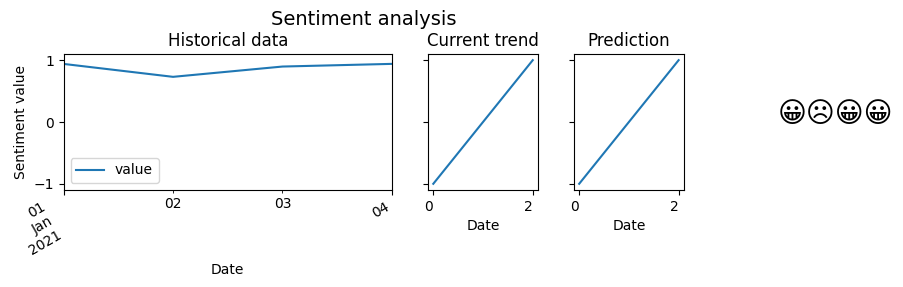

In [39]:
from analyzer.analyzer import Analyzer
import matplotlib.pyplot as plt


test_data = ["it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia ", 'This thing is pretty shit', 'life', 'ugly bad ugly']

date_time = ["2021-01-01", "2021-01-02", "2021-01-03", "2021-01-04"]

analyzer = Analyzer('models', 'model.sav', 'vectorizer.sav')
results = analyzer.get_sentiment_analysis(test_data)
results = pd.Series(results).apply(lambda x: (2*x)-1)
results = index_dates(results,date_time)
plot_function(results, plot_path='out/graphs/foo.png')


In [5]:
from datetime import datetime
from collections import namedtuple



def parse_args(text:str):
    date_range = namedtuple("DateRange", ["date_from", "date_to"])
    try:
        split = text.split(' ')
        if len(split) == 0:
            return date_range(None, None)
        if len(split) == 1:
            datetime_from = datetime.strptime(split[0], '%d/%m/%Y')
            return date_range(datetime_from, datetime.today())
        else:
            datetime_from = datetime.strptime(split[0], '%d/%m/%Y')
            datetime_to = datetime.strptime(split[1], '%d/%m/%Y')
            delta = datetime_to - datetime_from
            if delta.days < 0:
                return date_range(datetime_to, datetime_from)
            return date_range(datetime_from, datetime_to)
    except Exception:
        print('Bad format of args.')
        return date_range(None, None)


In [13]:
print(parse_args('25/12/2021'))
print(parse_args('asddas'))
print(parse_args('28/12/2021 27/12/2021'))
x1, x2 = parse_args('asd')
print(x1, x2)

DateRange(date_from=datetime.datetime(2021, 12, 25, 0, 0), date_to=datetime.datetime(2023, 3, 12, 11, 39, 45, 521104))
Bad format of args.
DateRange(date_from=None, date_to=None)
DateRange(date_from=datetime.datetime(2021, 12, 27, 0, 0), date_to=datetime.datetime(2021, 12, 28, 0, 0))
Bad format of args.
None None


In [11]:
stamp = int('1512085950')
date = datetime.fromtimestamp(stamp)

print(date)

2017-12-01 00:52:30


In [16]:
x1 is None or x2 is None

True